## Plot single time step and seasonal mean LFM maps of each fuel type
Last updated: Kevin Varga, 12/27/2024

**Inputs:**
* Netcdf file of predicted LFM of all four fuels
* CA Counties shapefile
* Thomas Fire shapefile

**Outputs:**
* Map of LFM of fuel type at individual time steps
* Option to loop through every time step and save every map
* Figure showing seasonal means of every fuel type

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib import ticker
import cartopy.io.shapereader as shpreader

In [2]:
grid_path = '/home/sbarc/students/varga/nasa/ch1/data/lfm_model/'
shp_path = '/home/sbarc/students/varga/nasa/data/shapefiles/'
output_path = '/home/sbarc/students/varga/nasa/ch1/figures/lfm_maps/'

In [3]:
# Open LFM dataset
lfm_ds = xr.open_dataset(grid_path + 'sba_lfm_1987-2019.nc')

In [4]:
# Read in county and Thomas Fire shapefiles
counties_shp = cfeature.ShapelyFeature(shpreader.Reader(shp_path + 'ca_counties.shp').geometries(),
                                       ccrs.PlateCarree(), edgecolor='black', facecolor='none')

thomas_fire_shp = cfeature.ShapelyFeature(shpreader.Reader(shp_path + 'thomas_fire.shp').geometries(),
                                          ccrs.PlateCarree(), edgecolor='black', facecolor='none')

### Plot single time step

In [5]:
# Find index of time step
np.where(lfm_ds['time'].values == np.datetime64('2005-04-01'))[0][0]

416

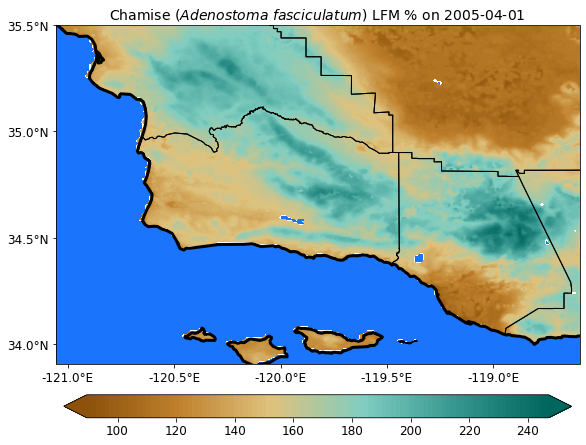

In [42]:
# Select fuel type and time step to plot
# 720 = Thomas Fire ignition
i = 416
fuel_type = 'chamise'
# Select map title based on fuel type
fuel_title = 'Chamise ($\it{Adenostoma}$ $\it{fasciculatum}$)'
#fuel_title = 'Chamise Old Growth ($\it{Adenostoma}$ $\it{fasciculatum}$)'
#fuel_title = 'Black Sage ($\it{Salvia}$ $\it{mellifera}$)'
#fuel_title = 'Bigpod Ceanothus ($\it{Ceanothus}$ $\it{megacarpus}$)'

# Set desired latitude and longitude map ticks
lat_ticks = [34, 34.5, 35, 35.5]
lon_ticks = [-119, -119.5, -120, -120.5, -121]

# Extract LFM dataset dimensions
lat = lfm_ds['latitude'].to_numpy()
lon = lfm_ds['longitude'].to_numpy()
times = lfm_ds['time'].to_numpy()

# Extract max/min LFM values and create colormap levels
min_value = lfm_ds['chamise'].isel(time=i).min().to_numpy().item()
max_value = lfm_ds['chamise'].isel(time=i).max().to_numpy().item()
cmap_levels = np.linspace(min_value, max_value, 101)

# Define custom colormap
#colors = ['brown', 'yellow', 'yellowgreen', 'green']
#cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors)
#colors = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#f5f5f5', '#c7eae5', '#80cdc1', '#35978f', '#01665e']
#colors = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#c7eae5', '#80cdc1', '#35978f', '#01665e']
colors = ['#8c510a', '#bf812d', '#dfc27d', '#80cdc1', '#35978f', '#01665e']
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

# Loop through every time step if saving all maps
#for time_stamp in times:

# Select a specific time stamp
lfm_values = lfm_ds[fuel_type].isel(time = i)

# Mask out ocean values
mask = np.isnan(lfm_values.to_numpy())
masked_data = np.array([[1 if np.isnan(val) else np.nan for val in row] for row in lfm_values.to_numpy()])

# Create a plot
fig = plt.figure(figsize=(14, 8), facecolor='white')
ax = plt.axes(projection=ccrs.PlateCarree())
# Set map extent
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
# Add features
ax.coastlines(linewidth=3)
ax.add_feature(counties_shp)
#ax.add_feature(thomas_fire_shp, edgecolor='red', lw=1.5)

# Add latitude and longitude tick marks
ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{l:.1f}°E' for l in lon_ticks], fontsize=12)
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax.set_yticklabels([f'{l:.1f}°N' for l in lat_ticks], fontsize=12)

# Plot LFM values
im = plt.contourf(lon, lat, lfm_values, transform=ccrs.PlateCarree(), 
                  cmap=cmap, levels=cmap_levels, extend='both')

# Adjust colorbar
cbar = plt.colorbar(im, pad = 0.07, shrink = 0.65, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
# Set integer ticks on the colorbar
tick_locator = ticker.MaxNLocator(integer=True)  # Force integer ticks
cbar.locator = tick_locator
cbar.update_ticks()

# Plot masked_data in blue for water values
oc = plt.contourf(lon, lat, masked_data, transform=ccrs.PlateCarree(), colors='#0165fc', alpha=0.9);

# Extract date
time_stamp = lfm_ds['time'][i].to_numpy()
# Set title
plt.title(fuel_title + ' LFM % on ' + str(time_stamp).split('T')[0], fontsize=14);
#plt.show();
fig.savefig(output_path + fuel_type + '/' + str(time_stamp).split('T')[0] + 
            '.png', dpi = 600, bbox_inches='tight');
#plt.close()

##### Find location of max value

In [24]:
da = lfm_ds[fuel_type].sel(time = time_stamp)
# Mask NaN values before finding the maximum
valid_values = np.ma.masked_invalid(da.values)

# Find the location of the maximum value in the masked array
max_location = np.unravel_index(np.argmax(valid_values, axis=None), valid_values.shape)

# Extract the latitude and longitude corresponding to the maximum value
max_latitude = da.latitude.values[max_location[0]]
max_longitude = da.longitude.values[max_location[1]]

print(f"The maximum value occurs at latitude {max_latitude}, longitude {max_longitude}.")

The maximum value occurs at latitude 34.78929901123047, longitude -120.630615234375.


### Plot seasonal means

In [11]:
def calculate_seasonal_means(ds):
    """Calculate seasonal means using meteorological seasons"""
    # Add season labels to the dataset
    ds = ds.assign_coords(season=ds.time.dt.season)
    
    # Calculate means for each season
    seasonal_means = ds.groupby('season').mean('time')
    
    # Reorder seasons to standard meteorological order (DJF, MAM, JJA, SON)
    season_order = ['DJF', 'MAM', 'JJA', 'SON']
    seasonal_means = seasonal_means.reindex(season=season_order)
    
    return seasonal_means

In [14]:
# Define color schemes for each variable
color_schemes = {
    'chamise': ['#8c510a', '#bf812d', '#dfc27d', '#80cdc1', '#35978f', '#01665e'],
    'chamise_old_growth': ['#8c510a', '#bf812d', '#dfc27d', '#80cdc1', '#35978f', '#01665e'],
    'sage_black': ['#8c510a', '#bf812d', '#dfc27d', '#80cdc1', '#35978f', '#01665e'],
    'ceanothus_bigpod': ['#8c510a', '#bf812d', '#dfc27d', '#80cdc1', '#35978f', '#01665e']
}

# Define titles for each variable
titles = {
    'chamise': 'Chamise (Adenostoma fasciculatum)',
    'chamise_old_growth': 'Chamise Old Growth (Adenostoma fasciculatum)',
    'sage_black': 'Black Sage (Salvia mellifera)',
    'ceanothus_bigpod': 'Bigpod Ceanothus (Ceanothus megacarpus)'
}

In [15]:
# Calculate seasonal means
seasonal_means = calculate_seasonal_means(lfm_ds)

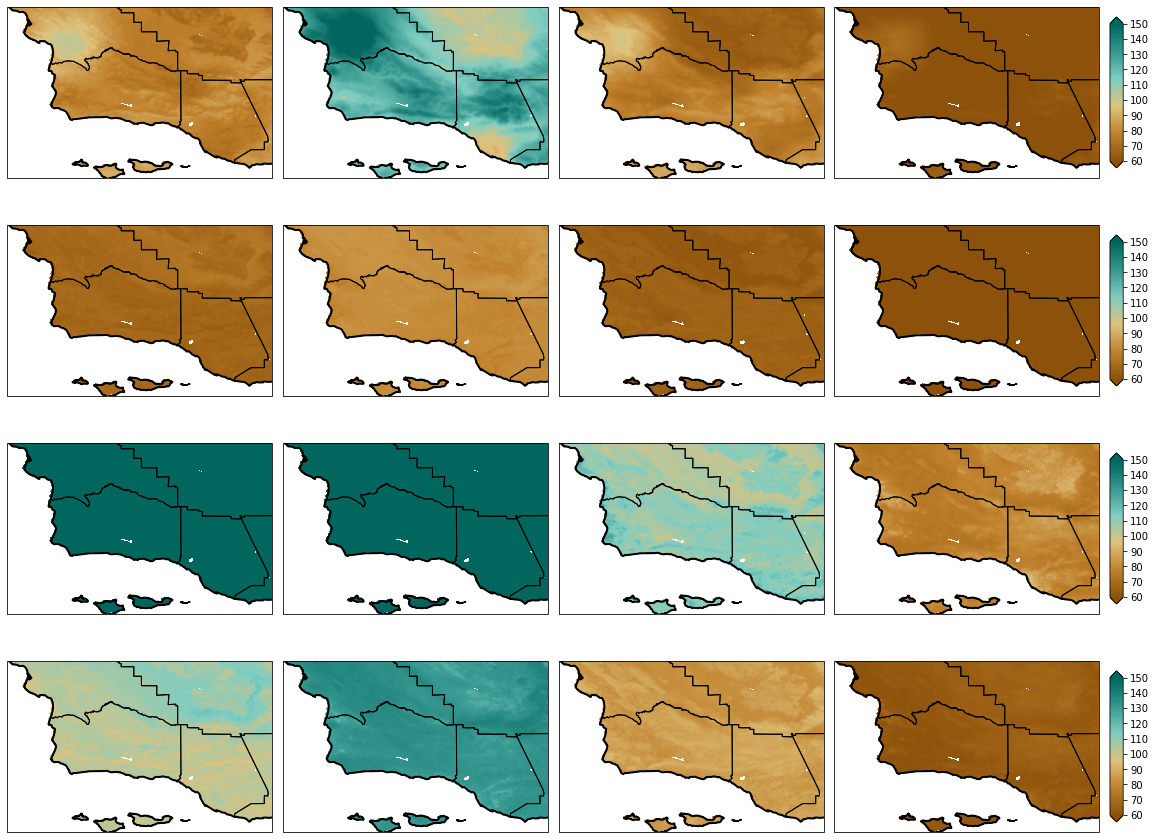

In [35]:
# Set map parameters
lat_ticks = [34, 34.5, 35]
lon_ticks = [-119, -120, -121]

# Create plots for each variable and season
variables = ['chamise', 'chamise_old_growth', 'sage_black', 'ceanothus_bigpod']
seasons = ['DJF', 'MAM', 'JJA', 'SON']

# Set up the figure and grid
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 5, width_ratios=[1, 1, 1, 1, 0.05],# height_ratios=[0.5, 0.5, 0.5, 0.5],
                      hspace=0.01, wspace=0.05)#,
                      #left=0.1, right=0.9, top=0.95, bottom=0.05)

# Create plots for each variable and season
for var_idx, var in enumerate(variables):
    # Create colormap for this variable
    cmap = mcolors.LinearSegmentedColormap.from_list("custom", color_schemes[var])
    
    # Get min and max values for fuel type across all seasons
    #min_value = seasonal_means[var].min().item()
    #max_value = seasonal_means[var].max().item()
    # Conversely, set same min and max value for every fuel type
    min_value = 60
    max_value = 150
    levels = np.linspace(min_value, max_value, 101)
    
    for season_idx, season in enumerate(seasons):
        # Create subplot
        ax = fig.add_subplot(gs[var_idx, season_idx], projection=ccrs.PlateCarree())
        
        # Set map extent and features
        ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
        ax.coastlines(linewidth=2)
        ax.add_feature(counties_shp)
        
        # Adjust tick parameters to minimize padding
        ax.tick_params(pad=2)
        
        # Add latitude and longitude tick marks (only on leftmost and bottom plots)
        #if season_idx == 0:  # leftmost plots
        #    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
        #    ax.set_yticklabels([f'{l:.1f}°N' for l in lat_ticks], fontsize=10)
        #else:
        #    ax.set_yticks([])
            
        #if var_idx == 3:  # bottom plots
        #    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
        #    ax.set_xticklabels([f'{l:.1f}°E' for l in lon_ticks], fontsize=10)
        #else:
        #    ax.set_xticks([])
        
        # Plot values
        im = plt.contourf(lon, lat, seasonal_means[var].sel(season=season),
                         transform=ccrs.PlateCarree(), 
                         cmap=cmap, levels=levels, extend='both')
    
        # Add titles (only on top row for seasons, leftmost for variables)
        #if var_idx == 0:
        #    ax.set_title(season, fontsize=12, pad=5)
            
    # Add colorbar for each variable row
    cax = fig.add_subplot(gs[var_idx, -1])
    # Adjust the position of the colorbar axis to make it shorter
    pos = cax.get_position()
    #cax.set_position([pos.x0, pos.y0, pos.width, pos.height*0.8])  # This makes it 60% of original height
    cax.set_position([pos.x0, pos.y0 + pos.height*0.15, pos.width, pos.height*0.7])  # This makes it 60% of original height
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=10)
    tick_locator = ticker.MaxNLocator(integer=True)
    cbar.locator = tick_locator
    cbar.update_ticks()
    #if var_idx == 0:
    #    cbar.set_label('LFM %', fontsize=12)
    
    # Add variable names along the left side
    #ax = fig.add_subplot(gs[var_idx, 0])
    #ax.axis('off')
    #ax.text(-0.5, 0.5, titles[var], 
    #        rotation=0, 
    #        transform=ax.transAxes,
    #        fontsize=12,
    #        horizontalalignment='right',
    #        verticalalignment='center')

plt.show()